In [1]:
import sys

sys.path.append('../model_generator')
sys.path.append('../patient_sample_generator')
sys.path.append('../ebm')
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

from model_generator.model_factory import ModelFactory
from patient_sample_generator.sample_generator import SampleGenerator
from ebm.ebm_transformer import EBMModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr, kendalltau


# Get the absolute path of the current notebook


#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

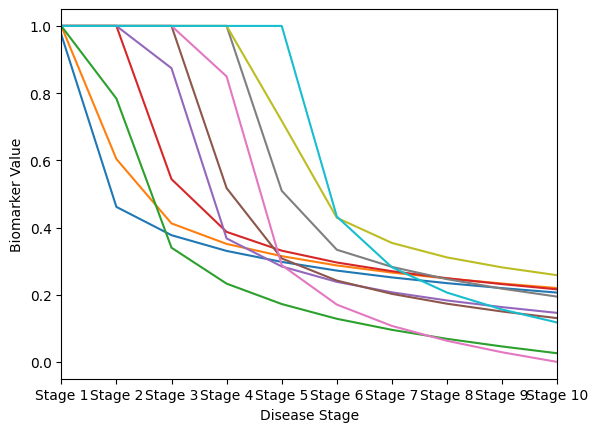

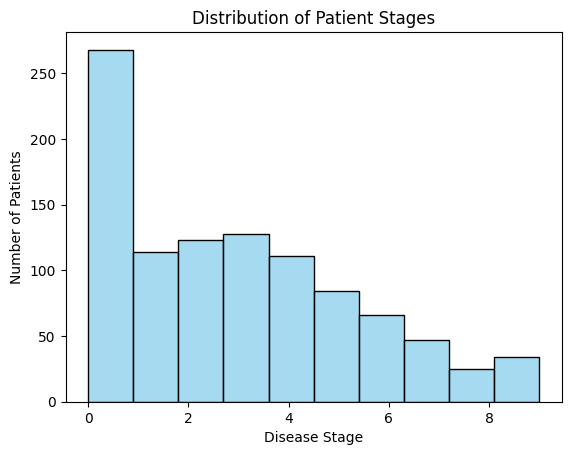

In [2]:
params = {
    'n_stages': 10,
    'l1_mean': 5.0,
    'l2_mean': 5.0,
    'gamma_mean': 0.9,
    'eta_mean': 0.3,
    'k_ij_value': 0.6,
    'random_state': 10,
    'start_time': 0,
    'end_time': 150,
    'steps': 200,
    'staging': 'whole',
    'matrix_type': 'Tridiagonal',
    'convergence_threshold': 1e-4,
    'flip_v': True
}

model = ModelFactory.create_model('acp', **params)
model.fit()
prior = model.get_connectivity_matrix()
model.plot()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.2,
                         random_state=2)

sample.plot_stage_histogram()
